In [1]:
import torch
from torch import nn
import circuits as ckt
import learn as lrn
from models import Solver
from inputs import Input

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 3 nodes and 3 elements
[0, 1, 2]
[(2 , 0), (1 , 0), (2 , 1)]
[(2, {}), (0, {}), (1, {})]
[(2, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': None, 'v': None, 'attr': 1}), (2, 1, 0, {'kind': <Kinds.R: 2>, 'i': None, 'v': 0.5, 'attr': None}), (1, 0, 0, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': 10})]


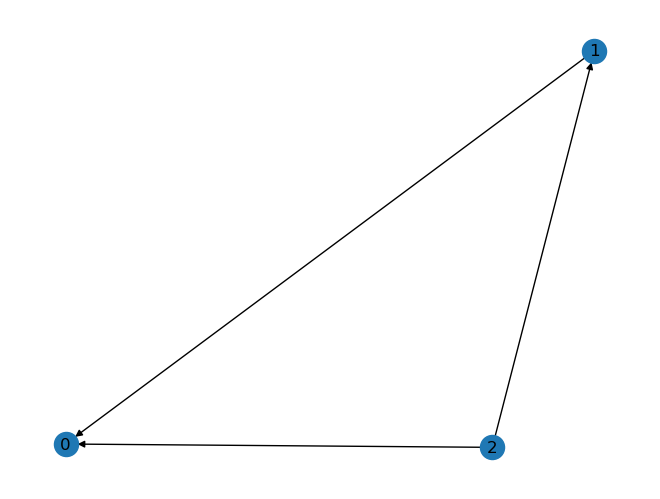

In [3]:
vr = ckt.Circuit()

# v_source = vr.add_element(kind=ckt.Kinds.IVS)
# r1 = vr.add_element(kind=ckt.Kinds.R)
# v_source.connect(v_source.high, r1.high)
# v_source.connect(v_source.low, r1.low)
# Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# # Case 2 one resisance unknown
# v_source.attr = 1
# v_source.i = -10
# # Case 3 one voltage and one current known
# v_source.attr = 1
# r1.i = 10

v_source = vr.add_element(kind=ckt.Kinds.IVS)
r1 = vr.add_element(kind=ckt.Kinds.R)
r2 = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, r1.high)
r1.connect(r1.low, r2.high)
v_source.connect(v_source.low, r2.low)
# # Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# r2.attr = 1e6
# # Case 2 one resisance unknown
v_source.attr = 1
r1.attr = 10
r2.v = 0.5

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Create Solver

In [4]:
input = Input(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:65: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [5]:
import time
start_time = time.time()
model = Solver(input=input,attr=input.attr_param)
X = model()
end_time = time.time()

In [6]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 2.0055770874023438 ms


In [7]:
model.build()

(tensor([[ -1.0000,  -1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000],
         [  1.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,
           -1.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           -0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,  -0.0000,
           -1.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,
            0.0000],
         [  0.0000, -10.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
            0.0000],
         [  0.0000,   0.0000,  -0.7709,   0.0000,   0.0000,   1.0000,   0.0000,
            0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,
            0.0000]], grad_fn=<CatBackward0>),
 tensor([[0.0000],
         [0.0000],
         [0.0000],
        

# Learn attributes

In [8]:
num_epochs = 10000
prev_loss = 0.1

model = Solver(input=input, attr=input.attr_param)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)
loss, _ = lrn.train(model,optimizer,nn.MSELoss(),None,None)
print(f'init params: {input.attr_param}')
print(f'init loss: {loss.item()}')

epoch = 0

while(epoch < num_epochs):
    loss, _ = lrn.train(model,optimizer,nn.MSELoss(),None,None)
    if(loss < 1e-6):
            break
    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes')
print(f'solution = {model()[1]}')
print(f"attributes = {input.attr_param}")

init params: Parameter containing:
tensor([[ 1.0000],
        [10.0000],
        [ 0.7809]], requires_grad=True)
init loss: 0.007003059610724449
Done! at 7270 passes
solution = tensor([[-0.0522],
        [ 0.0501],
        [ 0.0543],
        [ 1.0002],
        [ 0.5013],
        [ 0.4996],
        [-0.5011],
        [ 0.4994]], grad_fn=<LinalgLstsqBackward0>)
attributes = Parameter containing:
tensor([[ 1.0000],
        [10.0000],
        [ 9.1999]], requires_grad=True)
